# Required installations for running notebook

In [1]:
!pip install -r requirements.txt --quiet

# PCS956 Project - Diabetes Health Indicators: Exploring Causality for Efficient ML and Explainability

Group members: Bjørn Christian Weinbach

## Overview
This project explores the role of causal understanding in machine learning models using the **CDC Diabetes Health Indicators dataset**. The primary objective is to evaluate how integrating causal knowledge impacts model performance and interpretability. We will:
- Construct a **Directed Acyclic Graph (DAG)** to represent potential causal relationships within the dataset.
- Train baseline machine learning models and compare them to models that leverage causal structures.
- Use explainability tools to analyze model predictions, emphasizing the influence of causal features.

## Dataset Description
### Source and Context
The CDC Diabetes Health Indicators dataset provides healthcare statistics and lifestyle survey information for individuals, including their diabetes diagnosis. This dataset is designed to explore the relationships between various health indicators and the likelihood of diabetes or prediabetes.

### Characteristics
- **Type**: Tabular, Multivariate
- **Subject Area**: Health and Medicine
- **Associated Tasks**: Classification
- **Feature Types**: Categorical, Integer
- **Number of Instances**: 253,680
- **Number of Features**: 21
- **Missing Values**: No

### Data Structure and Variables
The dataset includes 21 variables:
- **Diabetes_binary**: Target variable indicating diabetes status (0 = no diabetes, 1 = prediabetes or diabetes).
- **Features**:
  - **HighBP**: High blood pressure (0 = no, 1 = yes).
  - **HighChol**: High cholesterol (0 = no, 1 = yes).
  - **CholCheck**: Cholesterol check in the past 5 years (0 = no, 1 = yes).
  - **BMI**: Body Mass Index (integer value).
  - **Smoker**: Smoked at least 100 cigarettes in lifetime (0 = no, 1 = yes).
  - **Stroke**: History of stroke (0 = no, 1 = yes).
  - **HeartDiseaseorAttack**: Coronary heart disease or myocardial infarction (0 = no, 1 = yes).
  - **PhysActivity**: Physical activity in the past 30 days, excluding job-related (0 = no, 1 = yes).
  - **Income**: Categorical income levels.
  - **Education**: Categorical education levels.
  - **Additional features**: Demographics (e.g., age, sex), mental health indicators, etc.

### Project Steps
1. **Data Import and Preprocessing**:
   - Load the dataset and prepare it for analysis.
   - Check data consistency and handle any preprocessing requirements.

2. **DAG Construction and Validation**:
   - Build an initial DAG using domain expertise and statistical insights.
   - Validate the DAG through iterative pruning and edge addition to ensure acyclic structure.

3. **Model Development**:
   - Develop baseline models (e.g., Logistic Regression, Random Forest).
   - Train a causally-informed model using selected variables from the DAG.

4. **Explainability Analysis**:
   - Integrate SHAP or LIME to assess feature importance and model predictions.
   - Focus on how causal features contribute to explainability.

5. **Conclusion**:
   - Summarize the impact of causal integration on model performance and interpretability.
   - Discuss future directions for refining causal approaches in ML.

## Additional Information
The CDC created this dataset to understand the relationship between lifestyle factors and diabetes prevalence in the U.S. It includes sensitive data like gender, income, and education level, and it has been preprocessed to include no missing values. Further details can be found at the CDC's [dataset page](https://www.cdc.gov/brfss/annual_data/annual_2014.html).

# **Data Import and Preprocessing**:

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


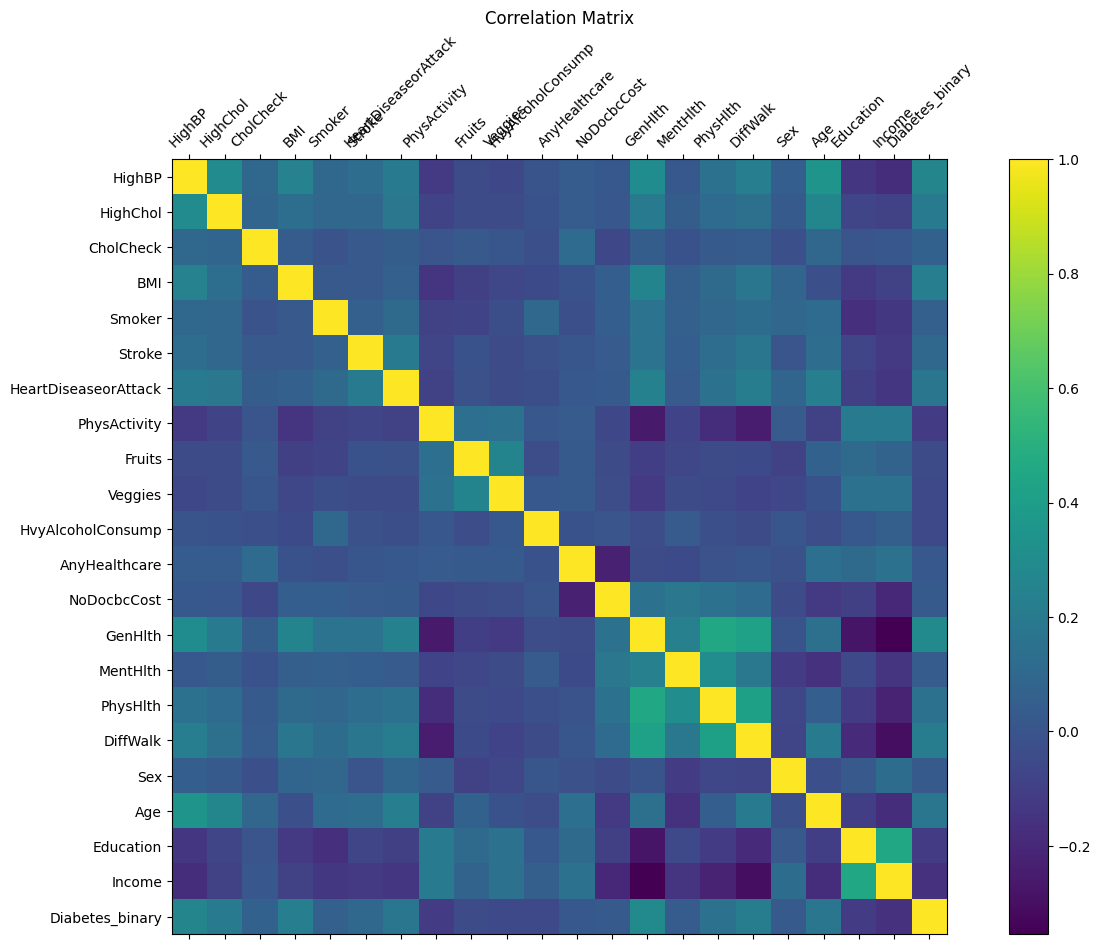

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Machine learning and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, roc_curve, auc, roc_auc_score, 
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE

# Statistical models
import statsmodels.api as sm

# Causal inference and Bayesian models
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square, pearsonr

# Load the data as per the instructions provided
from ucimlrepo import fetch_ucirepo
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Add the target variable 'Diabetes_binary' to the dataset for correlation analysis
X = X.assign(Diabetes_binary=y)

# Calculate the Spearman correlation matrix for the dataset
correlation_matrix = X.corr(method='spearman')

f = plt.figure(figsize=(16, 10))
plt.matshow(correlation_matrix, fignum=f.number)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=12);

In [3]:
correlation_matrix['Diabetes_binary'].sort_values()

Income                 -0.163305
Education              -0.120038
PhysActivity           -0.118133
HvyAlcoholConsump      -0.057056
Veggies                -0.056584
Fruits                 -0.040779
AnyHealthcare           0.016255
Sex                     0.031430
NoDocbcCost             0.031433
MentHlth                0.040049
Smoker                  0.060789
CholCheck               0.064761
Stroke                  0.105816
PhysHlth                0.156752
HeartDiseaseorAttack    0.177282
Age                     0.177684
HighChol                0.200276
DiffWalk                0.218344
BMI                     0.226314
HighBP                  0.263129
GenHlth                 0.287697
Diabetes_binary         1.000000
Name: Diabetes_binary, dtype: float64

# **Checking for Duplicates**

When training machine learning models, particularly algorithms like logistic regression and generalized linear models (GLMs), it is crucial to ensure that the dataset does not contain duplicate entries. While logistic regression and GLMs do not strictly require observations to be **identically distributed**, they do assume **independence of observations**. This means that each observation should not influence or provide information about another. Duplicate observations can lead to biased model training, overfitting, or misinterpretations of feature importance, ultimately impacting the validity of the model's conclusions.

**Investigation of Duplicates and Temporal Dependencies:**  
Our diabetes dataset, containing health indicators, may have temporal elements or repeated measurements. It is essential to investigate whether duplicates represent legitimate repeated observations, such as those from longitudinal studies, or are errors. If these duplicates are associated with a time series structure, it indicates potential temporal dependencies. These dependencies must be understood and properly handled to avoid violating the independence assumption critical for reliable model performance and interpretation.

By searching for duplicates and examining their nature, we can identify potential issues related to the independence assumption and determine if our dataset has temporal patterns that need special handling. This ensures that the data meets the requirements for valid and unbiased model training.

In [4]:
# Extract the IDs
ids = cdc_diabetes_health_indicators.data.ids

# Check for duplicate IDs
duplicate_ids = ids.duplicated(keep=False)  # Find duplicated IDs, keeping all instances of duplicates
duplicates_df = ids[duplicate_ids]

# Display the number of duplicate entries and a sample of the duplicated IDs
print(f"Number of duplicate entries found: {duplicates_df.shape[0]}")
print("Sample of duplicate entries:")
print(duplicates_df.head())

# Display unique counts for the duplicated IDs
unique_counts = duplicates_df.value_counts()
print("ID counts in duplicate entries:")
print(unique_counts)

Number of duplicate entries found: 0
Sample of duplicate entries:
Empty DataFrame
Columns: [ID]
Index: []
ID counts in duplicate entries:
Series([], Name: count, dtype: int64)


# **DAG Construction and Validation**

In the process of constructing and validating a Directed Acyclic Graph (DAG) for our project, we rely on a foundational approach that combines theoretical understanding with practical algorithmic applications. This approach allows us to construct a DAG that accurately represents the relationships between the variables in our dataset. The validation of edges in the DAG plays a critical role in ensuring the graph’s accuracy and faithfulness to the underlying data relationships. Here, we delve into how we validate these edges using conditional independence tests and why selecting the correct statistical test for each data type is essential.

## The Role of Conditional Variables in Edge Validation

A crucial part of DAG construction is identifying the conditional dependencies between variables. In practical terms, this means determining if the relationship between two variables $X$ and $Y$ holds when conditioned on a set of other variables $Z$. Conditional independence tests are performed iteratively to assess whether an edge between two nodes should exist or be removed based on their conditional dependencies.

The PC algorithm, which we use to build the DAG, begins with a fully connected graph and iteratively prunes edges by testing conditional independence:

1. **Initialize the Graph**: The graph starts with all possible edges between nodes.
2. **Conditional Independence Testing**: For each pair of connected nodes $(X, Y)$, we test if they are conditionally independent given a conditioning set $Z$ of size $d$. If $X$ and $Y$ are found to be conditionally independent given $Z$, the edge between them is removed.
3. **Iterative Pruning**: The process repeats, incrementing $d$, until no further edges can be removed without violating the conditions of the algorithm.

## The Nature of Our Data and Test Selection

Our dataset comprises both **binary** and **numerical** features:

- **Binary Variables**: Variables such as `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, and `PhysActivity` are binary, indicating the presence (1) or absence (0) of a condition or behavior.
- **Numerical Variables**: Features like `BMI` are represented as integer values that provide quantitative information about an individual's body characteristics.

Given the mixed nature of the data, it is essential to choose the appropriate statistical test for each pair of variables when testing conditional independence:

- **Chi-Squared Test**: Used for pairs of binary or categorical variables. This non-parametric test evaluates whether two variables are independent by comparing the observed frequencies in the contingency table with the expected frequencies if the variables were truly independent.
- **Pearson Correlation Test**: Applied when at least one of the variables is numerical. This test assesses the linear relationship between two continuous variables. When used in conditional independence testing, the correlation test considers whether the association between variables holds when conditioned on another variable.

## Selective Test Application in the PC Algorithm

Our algorithm dynamically selects between the Chi-squared test and Pearson correlation based on the types of variables being tested:

- **Binary vs. Binary**: If both $X$ and $Y$ are binary, the Chi-squared test is applied. This test effectively determines if the presence or absence of one variable is independent of the other within the context of the conditioning set $Z$.
- **Numerical or Mixed Types**: If at least one variable is numerical, the Pearson correlation test is used. This approach calculates the linear relationship between $X$ and $Y$ and verifies its significance, even when conditioned on $Z$.

This dynamic approach to choosing the statistical test ensures that the algorithm maintains accuracy and efficiency in identifying valid edges for the DAG.

## Detailed Example of Edge Validation

Consider the pair $(X, Y)$ with a conditioning set $Z$:

1. **Initial Check**: Start with a set $Z$ of size $d = 0$ (i.e., no conditioning set).
2. **Statistical Test**:
   - If $X$ and $Y$ are binary (e.g., `HighBP` and `HighChol`), apply the **Chi-squared test**.
   - If $X$ is binary and $Y$ is numerical (e.g., `HighBP` and `BMI`), apply the **Pearson correlation test**.
3. **Conditional Independence Result**:
   - If the test result indicates that $X$ and $Y$ are independent given $Z$, the edge is removed.
   - If they are not independent, retain the edge and continue with larger conditioning sets.

## Significance Level and Edge Retention

The significance level $\alpha$ plays a crucial role in these tests. It determines the threshold for rejecting the null hypothesis of independence:

- **Chi-Squared Test**: If the p-value is greater than $\alpha$, independence is assumed, and the edge is removed.
- **Pearson Correlation**: Similarly, if the p-value of the correlation test is above $\alpha$, the variables are deemed independent given $Z$.

This rigorous approach ensures that only statistically significant edges remain in the final DAG, aligning with the causal structure inferred from the data.

## Conclusion

The construction and validation of a DAG using conditional independence tests involve a detailed iterative process where each edge is evaluated based on its dependency, conditioned on subsets of the graph. By leveraging the properties of our dataset—binary and numerical variables—we dynamically apply the most appropriate test, either Chi-squared or correlation, ensuring that our final model accurately represents the underlying causal structure.


In [5]:
# Variable to conditionally run computationally intensive calculations
estimate_dag = False

X_sample = X

pc_estimator = PC(data=X_sample)

def dynamic_ci_test(data):
    def inner_ci_test(X, Y, Z, **kwargs):
        is_X_categorical = data[X].nunique() <= 2
        is_Y_categorical = data[Y].nunique() <= 2

        if is_X_categorical and is_Y_categorical:
            return chi_square(X=X, Y=Y, Z=Z, **kwargs)
        else:
            return pearsonr(X=X, Y=Y, Z=Z, **kwargs)

    return inner_ci_test

if estimate_dag:
    dag = pc_estimator.estimate(
        variant='parallel',
        ci_test=dynamic_ci_test(X_sample),
        significance_level=0.1,
        show_progress=True
    )

## Hyperparameters and its impact on the resulting DAG

The PC algorithm has two important hyperparameters. These being:

- significance_level (default 0.01): This values sets the threshold of what p-value the independence test needs for the PC 
    algorithm to consider nodes conditionally independent and retain the edge in the graph. A higher p-value means more edges will
    be retained.
- max_cond_vars (default 5): The size of the conditioning set $Z$. 

We had to do som trial and error to find appropriate thresholds. Here are some of the resulting graphs:

## $p=0.01$ and $Z_\text{max} = 5$

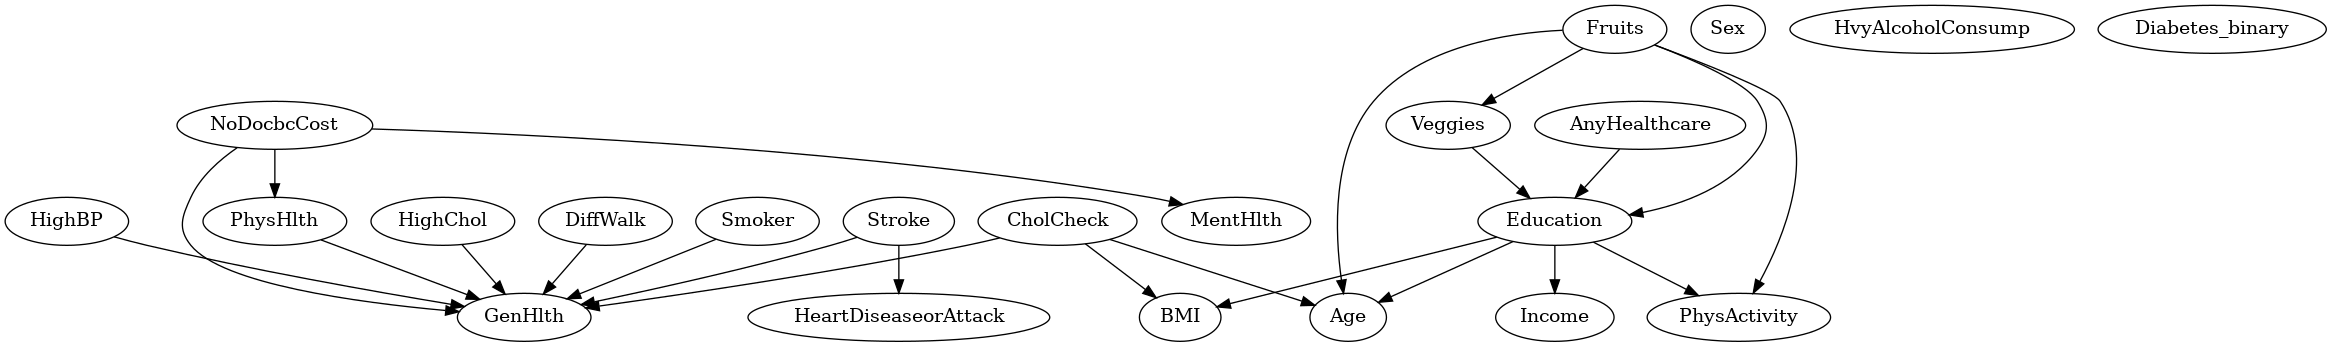

In [6]:
Image(filename="learned_dag_p001_maxcond_5.png")

Asone can see. Diabetes_binary has been isolated as its own node with no connections.
This is unfortunate, as that is the variable we want to predict. Let us try another
selection of hyperparameters.

## $p = 0.01$ and $Z_\text{max} = 2$

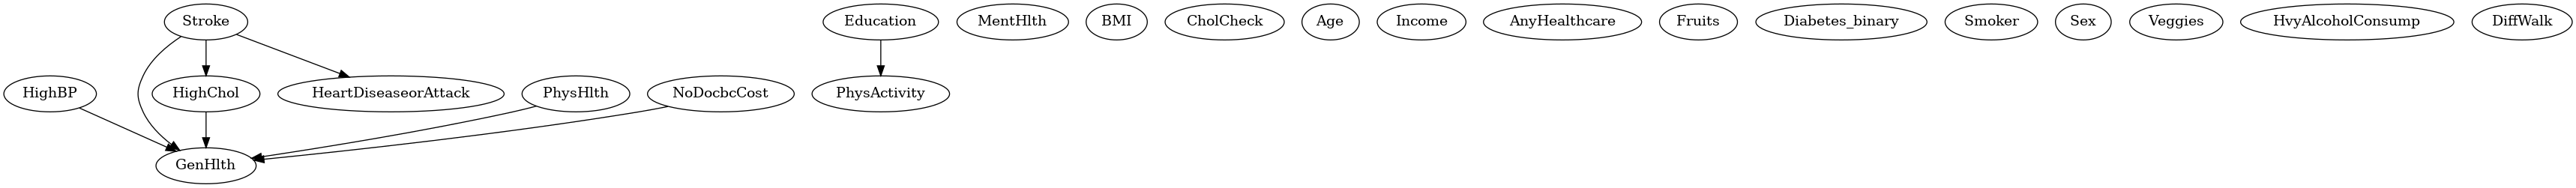

In [7]:
Image(filename="learned_dag_p001_maxcond_2.png")

This has the same outcome. diabetes_binary is still excluded from the graph. Let us set a higher threshold to retain more edges.

## $p = 0.1$ and $Z_max = 5$

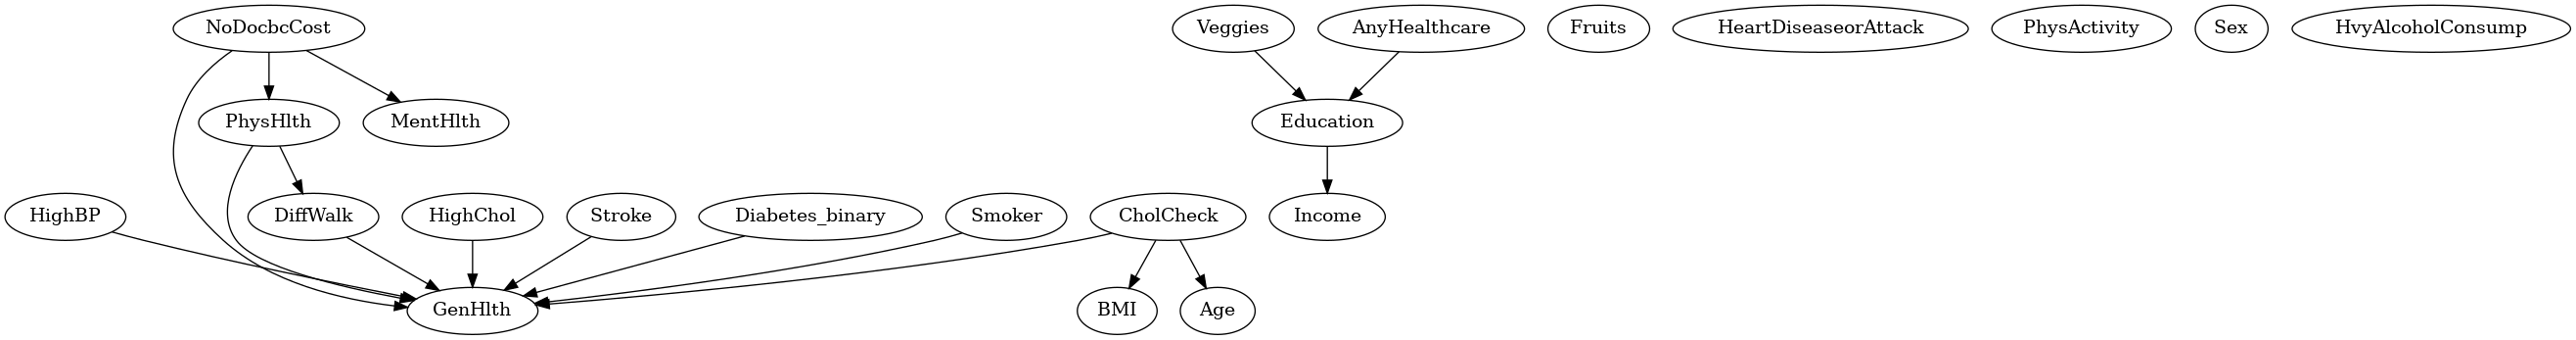

In [8]:
Image(filename="learned_dag_p01_maxcond_5.png")

Here we have a more meaningful DAG. 

This resulting dag has the following relationships:

- NoDocbcCost: Not being able to afford going to a physician has a causal relationship to physical health and mental health
- PhysicalHealth has a causal relationship to difficulty walking and a patiens general health.
- General health seems to be a important aggregate variable. It has the following parents
    - Difficulty walking, High Cholesterol, Stroke, **Diabetes_binary**, being a smoker, and if Cholesterol has been checked the last 5 years.
- General Health and its parents is thus good variables for predicting diabetes_binary.

We will test our model using the whole dataset as well as the following subset:

- DiffWalk
- HighChol
- Stroke
- **Diabetes_binary**
- Smoker
- CholCheck
- GenHlth

# **Model Development**

## Logistic Regression

### Why Logistic Regression?
Logistic regression was chosen for its interpretability and linear nature. Unlike more complex models, logistic regression provides a clear and straightforward understanding of how features affect the outcome. It models the probability of a binary outcome $Y$ given a set of features $X$. This interpretability makes it an ideal model when transparency in predictions is a priority.

### Theoretical Overview
Logistic regression is used for classification problems where the goal is to predict the probability of a binary outcome $Y$ given a set of features $X$. The model is based on the logistic function:

$$
P(Y=1 | X) = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 X_1 + \dots + \beta_p X_p))}
$$

Here, $\beta_0$ is the intercept, and $\beta_1, \dots, \beta_p$ are the model coefficients. The output, $P(Y=1 | X)$, is a probability value between 0 and 1.

### Interpretation
The weights in logistic regression are interpreted in terms of odds ratios. A weight $\beta_j$ indicates that increasing the feature $X_j$ by one unit changes the odds of $Y=1$ by a factor of $\exp(\beta_j)$. For example, if $\beta_j = 0.7$, increasing $X_j$ by one unit multiplies the odds by $\exp(0.7) \approx 2$.

### Generative vs. Discriminative Training
- **Generative Models**: These models, like Naive Bayes, aim to model the joint distribution $P(Y, X)$. They learn to generate both the target variable and the features, which can lead to higher bias due to independence assumptions among features. Generative training can perform better with limited data due to its regularizing nature but may struggle with larger data when these assumptions do not hold.
  
- **Discriminative Models**: Logistic regression is a discriminative model that directly models the conditional distribution $P(Y | X)$. It focuses solely on classifying the target given the features, making fewer assumptions and often achieving better performance on larger data sets. The advantage of discriminative training is that it aims to minimize classification error by focusing solely on the target variable's prediction.

### Graphical Representation
In Bayesian network terms, logistic regression can be visualized as a "star" Markov network with a central target variable $Y$ connected to all feature variables $X_1, \dots, X_n$. This structure aligns with the idea that logistic regression discriminatively models $P(Y | X)$ by treating $Y$ as dependent on all input features without explicitly modeling $P(X)$.

Using this model, conceptually that is modeling the following bayesian network.

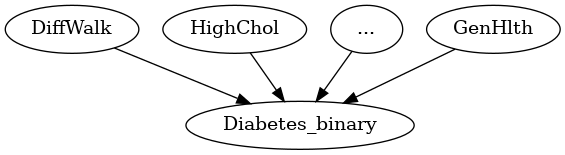

In [9]:
# Create an example Bayesian Network representing logistic regression structure
example_model = BayesianNetwork([('DiffWalk', 'Diabetes_binary'), ('HighChol', 'Diabetes_binary'), ('...', 'Diabetes_binary'), ('GenHlth', 'Diabetes_binary')])

# Convert to pygraphviz object
model_graphviz = example_model.to_graphviz()

# Plot and save the model in different formats
model_graphviz.draw("logistic_regression_dag.png", prog="dot")
model_graphviz.draw("logistic_regression_dag.pdf", prog="dot")
model_graphviz.draw("logistic_regression_dag.svg", prog="dot")

# Display the plot in Jupyter Notebook
Image(filename="logistic_regression_dag.png")

## Explore data

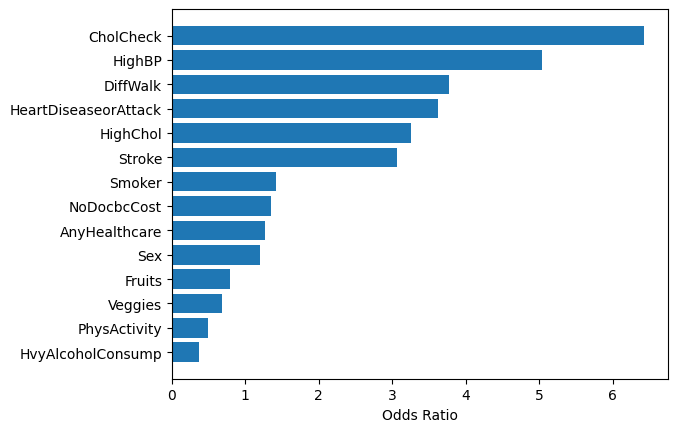

In [10]:
def OddsVisualization(df, variablesCol_name:str, targetCol_name: str):
    """
    This function will make a horizontal bar of the odds ratio (ranked)
    
    df = DataFrame
    variablesCol_name = the name of the DataFrame column containing the variables
    targetCol_name = the name of the DataFrame column containing the Odds Ratios
    """
    
    df.sort_values(by = [targetCol_name], ascending = True, inplace = True) #sorting values
    x,y = df[targetCol_name].tolist(), df[variablesCol_name].tolist() # getting the values
    
    axis = np.arange(1, len(y)+1) # just creating a valid axis for barh 
    
    plt.figure(dpi=100)
    plt.barh(axis,x)
    plt.yticks(axis, labels=y)
    plt.xlabel('Odds Ratio')
    plt.show()
    

def calc_odds(df, target_var:str, visualization = False):
    """
    This function will compute the odds ratio, and the p value for all binary 
    independent variables. The function will select only the variables with unique values = 2, it could be
    in category type, float, or int (0,1). Please note that if a non-binary variable is tried to fit it will
    raise an Exception and the function will not be executed.
    
    df = DataFrame
    target_var = name of column with the target variable
    visualization = plot a horizontal bar of the data
    
    return = DataFrame containing variables, odds ratio, p value
    """
    import pandas as pd
    from scipy import stats
    
    target_uniques = len(pd.unique(df[target_var]))
    
    if target_uniques != 2:
        raise Exception("Both independent and dependent variables must be 2 level size")
    
    val_cols = []
    
    results = {
        'variable': [],
        'odds_ratio': [],
        'p_val': []
    }
    
    for column in df.columns.tolist():
        if len(pd.unique(df[column])) == 2:
            val_cols.append(column)
    
    val_cols.remove(target_var)
    
    for independent_var in val_cols:
        table = pd.crosstab(df[target_var], df[independent_var])
        odds, p = stats.fisher_exact(table)
        
        results['variable'].append(independent_var)
        results['odds_ratio'].append(odds)
        results['p_val'].append(p)
    
    results = pd.DataFrame(results)
    
    if visualization == True:
        OddsVisualization(results, 'variable', 'odds_ratio')
        
    return results

Oddsratios = calc_odds(X, 'Diabetes_binary', True)

## Train Logistic Regression and interpret results

First, let us train the model on all the features.

Optimization terminated successfully.
         Current function value: 0.518381
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:               305458
Model:                          Logit   Df Residuals:                   305436
Method:                           MLE   Df Model:                           21
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.2521
Time:                        15:09:02   Log-Likelihood:            -1.5834e+05
converged:                       True   LL-Null:                   -2.1173e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.5114      0.054    -64.578      0.000      -3.618      -3.405

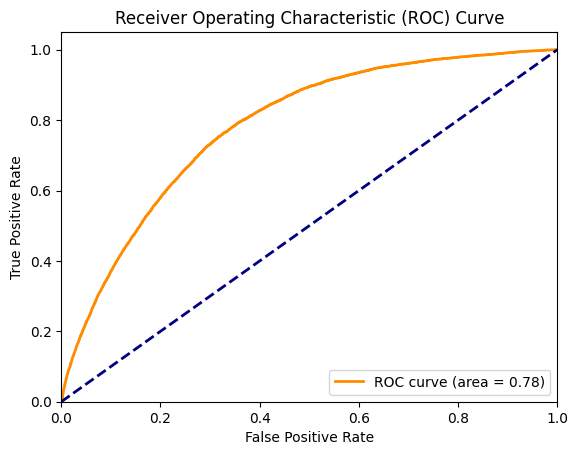


Coefficients and Odds Ratios with P-values:
                      Coefficient  Odds Ratio        P-value
const                   -3.511407    0.029855   0.000000e+00
HighBP                   0.562021    1.754213   0.000000e+00
HighChol                 0.317343    1.373473  3.140624e-270
CholCheck                1.145906    3.145290  8.135213e-239
BMI                      0.069925    1.072428   0.000000e+00
Smoker                  -0.400724    0.669835   0.000000e+00
Stroke                  -0.739755    0.477231  4.994618e-201
HeartDiseaseorAttack    -0.181210    0.834260   3.437376e-32
PhysActivity            -0.447032    0.639523   0.000000e+00
Fruits                  -0.467305    0.626689   0.000000e+00
Veggies                 -0.275537    0.759164  4.621545e-147
HvyAlcoholConsump       -2.179136    0.113139   0.000000e+00
AnyHealthcare           -0.339012    0.712474   6.647604e-59
NoDocbcCost             -1.173913    0.309155   0.000000e+00
GenHlth                  0.471918    1.6

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Diabetes_binary']), y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Add a constant to the balanced training data for the intercept term
X_train_sm = sm.add_constant(X_train_balanced)

# Fit the logistic regression model using statsmodels' Logit class
logit_model = sm.Logit(y_train_balanced, X_train_sm).fit()

# Print the model summary
print(logit_model.summary())

# Make predictions on the test set
X_test_sm = sm.add_constant(X_test)
y_pred_proba = logit_model.predict(X_test_sm)

# Generate class predictions based on a threshold (e.g., 0.5)
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Print classification report (precision, recall, F1-score, support)
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Calculate and print individual metrics
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract and display the coefficients, odds ratios, and p-values
coefficients = logit_model.params
odds_ratios = np.exp(coefficients)
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'P-value': logit_model.pvalues
})

# Display the summary DataFrame
print("\nCoefficients and Odds Ratios with P-values:")
print(summary_df)

### Visualise coeficcients

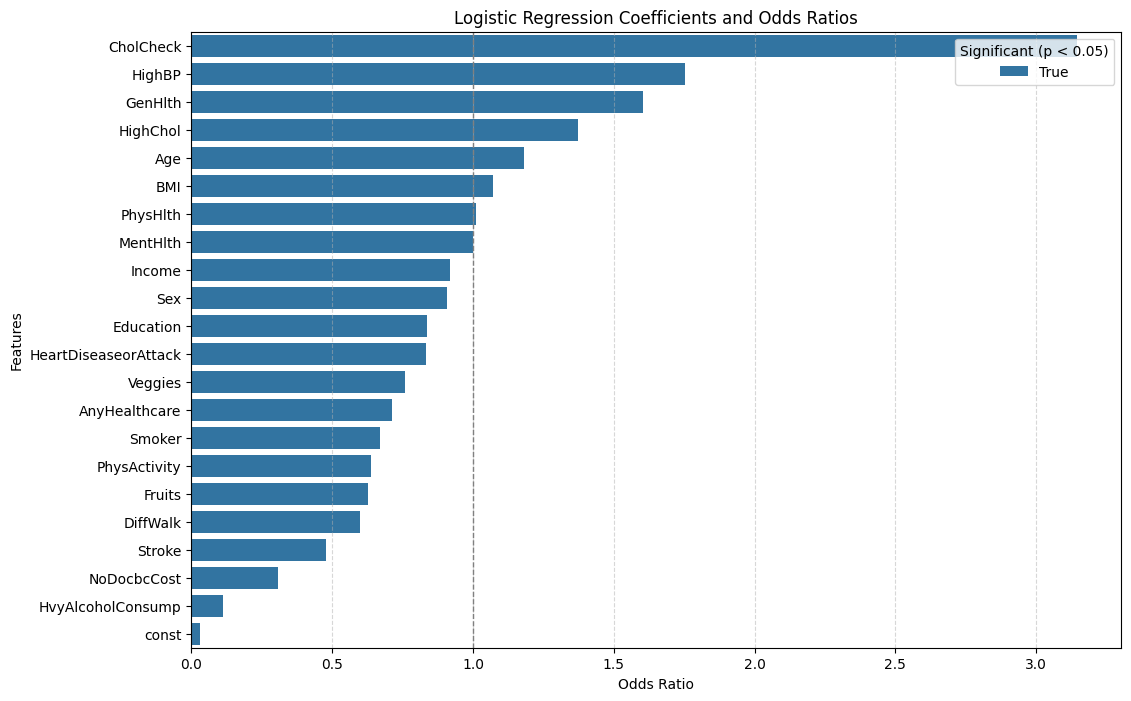

In [12]:
# Sort the DataFrame for better visualization
summary_df = summary_df.sort_values(by='Odds Ratio', ascending=False)

# Highlight significant features based on a p-value threshold (e.g., 0.05)
summary_df['Significant'] = summary_df['P-value'] < 0.05

# Create a horizontal bar plot for coefficients and odds ratios
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Odds Ratio',
    y=summary_df.index,
    data=summary_df,
    hue='Significant',
    dodge=False
)

# Add labels and title
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients and Odds Ratios')
plt.legend(title='Significant (p < 0.05)', loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)  # Reference line for odds ratio = 1

plt.show()

## Logistic Regression Results Summary

### Key Model Metrics:
- **Dependent Variable**: `Diabetes_binary`
- **Number of Observations**: 305,458
- **Log-Likelihood**: -158,340
- **Pseudo R-squared**: 0.2521
- **LLR p-value**: 0.000 (model is statistically significant)

### Explanation of Key Metrics:
- **Log-Likelihood**: The log-likelihood value measures the fit of the model to the data, with higher absolute values indicating a poorer fit. In this case, the final log-likelihood value is -158,340, reflecting how well the model's predictions align with the observed data. This metric is used in evaluating model performance but does not directly indicate predictive power.

- **Pseudo R-squared (0.2521)**: The Pseudo R-squared is similar in interpretation to the traditional R-squared in linear regression, providing a sense of the model’s explanatory power. Here, a Pseudo R-squared of 0.2521 implies that the model explains approximately 25.2% of the variation in the dependent variable (`Diabetes_binary`). While not as straightforward as R-squared in linear regression, it provides insight into model fit: higher values indicate better fit, but values are typically lower for logistic regression models compared to linear models.

- **LLR p-value**: The Likelihood Ratio (LR) test p-value here is 0.000, indicating that the overall model is statistically significant, meaning that at least one predictor significantly contributes to predicting the outcome (`Diabetes_binary`).

### Coefficient Interpretation
Each feature's coefficient ($\beta$) indicates the change in the log-odds of the outcome for a one-unit increase in that predictor. The odds ratio ($e^{\beta}$) provides a multiplicative interpretation of how the odds of the outcome change.

### Key Coefficients and Odds Ratios:
1. **CholCheck**:
   - **Coefficient**: 1.1459
   - **Odds Ratio**: 3.15
   - **Interpretation**: Having a cholesterol check increases the odds of having diabetes by approximately 3.15 times.

2. **HighBP (High Blood Pressure)**:
   - **Coefficient**: 0.5620
   - **Odds Ratio**: 1.75
   - **Interpretation**: High blood pressure increases the odds of diabetes by about 75%.

3. **HvyAlcoholConsump (Heavy Alcohol Consumption)**:
   - **Coefficient**: -2.1791
   - **Odds Ratio**: 0.11
   - **Interpretation**: Associated with an 89% reduction in the odds of diabetes, suggesting a significant negative relationship.

4. **Age**:
   - **Coefficient**: 0.1656
   - **Odds Ratio**: 1.18
   - **Interpretation**: Each unit increase in age increases the odds of diabetes by approximately 18%.

5. **BMI**:
   - **Coefficient**: 0.0699
   - **Odds Ratio**: 1.07
   - **Interpretation**: A one-unit increase in BMI raises the odds of diabetes by about 7.2%.

6. **GenHlth (General Health)**:
   - **Coefficient**: 0.4719
   - **Odds Ratio**: 1.60
   - **Interpretation**: Each unit increase in the general health score is associated with a 60% increase in the odds of diabetes.

### Significance of Predictors:
- **P-values**:
  - **Significant Predictors** (p < 0.05): Most predictors, including `CholCheck`, `HighBP`, `HighChol`, `Age`, `BMI`, `PhysActivity`, and others.
  - **Borderline or Low Impact Predictors**: While still statistically significant, `MentHlth` has a smaller coefficient and odds ratio close to 1, indicating a minimal impact on the outcome.

### Odds Ratio Insights:
- **Odds Ratios > 1**: Feature increases diabetes risk. E.g., `GenHlth` (1.60 odds ratio) and `HighBP` (1.75 odds ratio).
- **Odds Ratios < 1**: Feature reduces diabetes risk. E.g., `HvyAlcoholConsump` (0.11 odds ratio) suggests a strong decrease in risk, and `PhysActivity` (0.64 odds ratio) indicates physical activity is associated with reduced risk.
- **Odds Ratio ≈ 1**: Minimal impact on outcome. E.g., `MentHlth` (0.9987 odds ratio).

### Conclusion:
This model identifies significant health indicators affecting diabetes risk, emphasizing the importance of features like `HighBP`, `CholCheck`, and `GenHlth`. Notably, `HvyAlcoholConsump` shows a strong negative association with diabetes, warranting further investigation. Future iterations could include more complex modeling approaches to capture potential non-linear and interaction effects.


## Limit Logistic Regression to subset of data based on DAG

Optimization terminated successfully.
         Current function value: 0.574305
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:               305458
Model:                          Logit   Df Residuals:                   305451
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.1715
Time:                        15:09:07   Log-Likelihood:            -1.7543e+05
converged:                       True   LL-Null:                   -2.1173e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1726      0.039   -106.725      0.000      -4.249      -4.096
DiffWalk       0.4721      0.

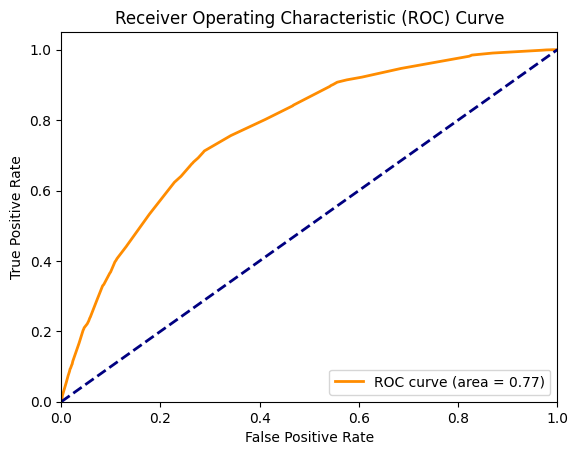


Coefficients and Odds Ratios with P-values:
           Coefficient  Odds Ratio       P-value
const        -4.172599    0.015412  0.000000e+00
DiffWalk      0.472120    1.603389  0.000000e+00
HighChol      0.868873    2.384223  0.000000e+00
Stroke        0.399682    1.491350  5.268408e-99
Smoker        0.060278    1.062132  3.075154e-13
CholCheck     1.638855    5.149272  0.000000e+00
GenHlth       0.688069    1.989870  0.000000e+00


In [13]:
# Select the subset of features
X_subset = X[[
    'DiffWalk',
    'HighChol',
    'Stroke',
    'Smoker',
    'CholCheck',
    'GenHlth'
]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Add a constant to the balanced training data for the intercept term
X_train_sm = sm.add_constant(X_train_balanced)

# Fit the logistic regression model using statsmodels' Logit class
logit_model = sm.Logit(y_train_balanced, X_train_sm).fit()

# Print the model summary
print(logit_model.summary())

# Make predictions on the test set
X_test_sm = sm.add_constant(X_test)
y_pred_proba = logit_model.predict(X_test_sm)

# Generate class predictions based on a threshold (e.g., 0.5)
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Print classification report (precision, recall, F1-score, support)
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Calculate and print individual metrics
precision = precision_score(y_test, y_pred_class, average=None)
recall = recall_score(y_test, y_pred_class, average=None)
f1 = f1_score(y_test, y_pred_class, average=None)
print(f"Class-wise Precision: {precision}")
print(f"Class-wise Recall: {recall}")
print(f"Class-wise F1 Score: {f1}")

# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract and display the coefficients, odds ratios, and p-values
coefficients = logit_model.params
odds_ratios = np.exp(coefficients)
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'P-value': logit_model.pvalues
})

# Display the summary DataFrame
print("\nCoefficients and Odds Ratios with P-values:")
print(summary_df)

## Random Forests

### Theory and Background
Random Forest is a powerful ensemble learning method used for both classification and regression tasks. It was developed as an improvement to decision trees, which, although interpretable, tend to overfit the data. By combining multiple decision trees into a "forest," Random Forests leverage the strengths of individual decision trees while mitigating their weaknesses.

#### How Random Forest Works:
1. **Bootstrap Aggregation (Bagging)**: Random Forests use bagging, a technique where multiple decision trees are trained on different subsets of the training data sampled with replacement. This results in diverse models that, when combined, reduce variance and improve the model's generalization.
2. **Feature Randomness**: In addition to training on different data samples, each tree in the forest considers a random subset of features at each split. This process ensures that the trees in the forest are decorrelated, which helps prevent overfitting and improves overall model robustness.
3. **Voting Mechanism**: For classification tasks, each tree in the forest makes a prediction, and the final output is determined by a majority vote (mode) across all the trees. For regression, the output is the average of all tree predictions.

### Advantages of Random Forests:
- **Reduction in Overfitting**: Random Forests are less prone to overfitting compared to individual decision trees due to the ensemble approach.
- **High Accuracy**: The combination of multiple trees generally leads to higher predictive accuracy.
- **Robustness to Noise**: Random Forests are resilient to noise and outliers in the dataset, making them a reliable choice for a wide range of applications.
- **Feature Importance**: Random Forests provide insights into which features are most important in making predictions, which can aid in feature selection and interpretability.

### Considerations for Using Random Forests:
- **Computationally Intensive**: Training multiple trees can be computationally demanding, especially for large datasets or many features.
- **Interpretability**: While Random Forests improve on the interpretability of black-box models like neural networks, they are still more complex than single decision trees.

### Application in the Project:
In this project, we use Random Forests to classify the likelihood of diabetes based on health indicators from the CDC Diabetes Health Indicators dataset. The dataset is imbalanced, with a greater proportion of non-diabetic instances. To address this, we apply the **Synthetic Minority Oversampling Technique (SMOTE)** to balance the training set, improving the model's ability to learn from underrepresented instances.

The following code demonstrates the training and evaluation of a Random Forest model on the balanced dataset.
|

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     65605
           1       0.31      0.47      0.38     10499

    accuracy                           0.79     76104
   macro avg       0.61      0.65      0.62     76104
weighted avg       0.83      0.79      0.80     76104



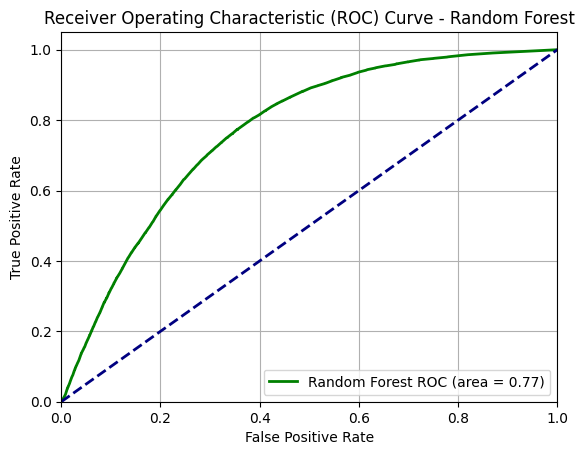

In [14]:
# Ensure 'Diabetes_binary' is not included in the features during training
if 'Diabetes_binary' in X.columns:
    X = X.drop(columns=['Diabetes_binary'])

# Split the data randomly into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier with balanced class weight and a random state
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Print the classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Calculate and plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Train RF on subset of data

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     65605
           1       0.28      0.72      0.40     10499

    accuracy                           0.71     76104
   macro avg       0.61      0.71      0.61     76104
weighted avg       0.85      0.71      0.75     76104



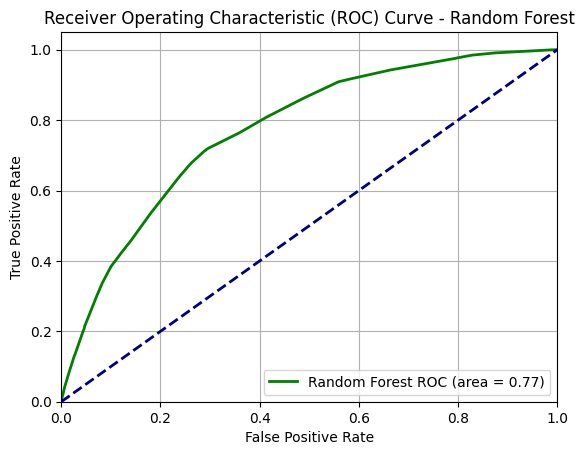

In [15]:
# Select the subset of features
X_subset = X[[
    'DiffWalk',
    'HighChol',
    'Stroke',
    'Smoker',
    'CholCheck',
    'GenHlth'
]]

# Split the data randomly into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42, shuffle=True)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier with balanced class weight and a random state
rf_model_subset = RandomForestClassifier()
rf_model_subset.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_rf = rf_model_subset.predict(X_test)
y_pred_proba_rf = rf_model_subset.predict_proba(X_test)[:, 1]

# Print the classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Calculate and plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Random Forests with Explainability Using Shapley Values

### Theory and Background

#### Intrinsic vs Post-Hoc Explanations
Interpretability methods can be categorized as intrinsic or post-hoc:
- **Intrinsic explanations**: Models that are inherently interpretable due to their simple structure, such as linear regression or decision trees.
- **Post-hoc explanations**: Methods applied after model training to interpret complex models, such as random forests or neural networks. Shapley values fall under this category, providing insights after the model has been trained.

#### Global vs Local Explanations
Interpretation methods can also be categorized based on their scope:
- **Global explanations**: These explain the overall behavior of the model.
- **Local explanations**: These focus on individual predictions, providing insight into how each feature contributes to a single output.

### Shapley Values in Machine Learning
Shapley values, derived from cooperative game theory, are used to fairly distribute the "payout" (prediction) among feature values. In machine learning, each feature value is considered a "player" in a coalition contributing to a model's prediction.

#### Key Properties of Shapley Values:
1. **Efficiency**: The sum of Shapley values for all features equals the difference between the prediction and the average prediction across the dataset.
2. **Symmetry**: If two features contribute equally to all coalitions, they receive the same Shapley value.
3. **Dummy Player**: A feature that does not contribute to any prediction has a Shapley value of zero.
4. **Additivity**: For ensemble models, Shapley values can be averaged across individual model predictions.

### Calculating Shapley Values
The Shapley value for a feature $i$ in a model with $n$ features is calculated using:

$$
\varphi_i(v) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! \, (n - |S| - 1)!}{n!} \left( v(S \cup \{i\}) - v(S) \right)
$$

Where:
- $S$ is a subset of features.
- $v(S)$ is the model's prediction for coalition $S$, marginalized over other features.

This approach ensures that each feature's contribution to the prediction is fair and accounts for all possible coalitions.

### Application to the Random Forest Model

To understand why the Random Forest model makes certain predictions, we use **SHAP (SHapley Additive exPlanations)**, a practical tool for computing Shapley values. SHAP provides both global insights (which features are most important overall) and local explanations (how features contribute to a single prediction).

## SHAP for RF trained on the full dataset

Calculating SHAP values with multiprocessing and tqdm...


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Plotting SHAP summary bar plot...


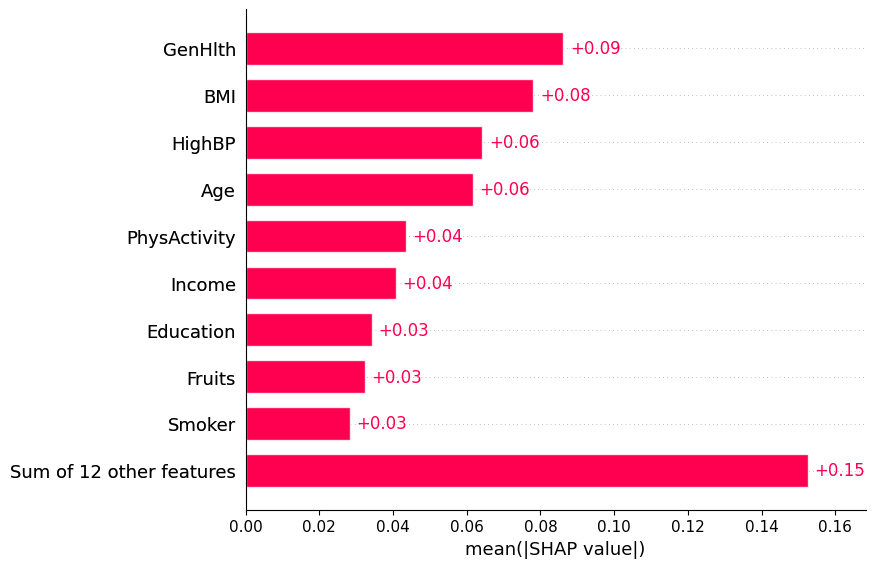

In [16]:
import shap
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Create an explainer for the trained Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Split the data randomly into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

subset_size = 1000
X_test_subset = X_test.iloc[:subset_size]

# Function to calculate SHAP values for a single instance
def calculate_shap_value(index):
    shap_values = explainer.shap_values(X_test_subset.iloc[index:index + 1], check_additivity=False)
    return shap_values if isinstance(shap_values, list) else [shap_values]

# Calculate SHAP values using multiprocessing for parallelization
print("Calculating SHAP values with multiprocessing and tqdm...")
with ProcessPoolExecutor() as executor:
    shap_values_list = list(tqdm(executor.map(calculate_shap_value, range(len(X_test_subset))), total=len(X_test_subset)))

# Combine SHAP values into a single array (ensure correct format)
# Select the SHAP values for class 1 (positive class)
shap_values_combined = np.vstack([shap_values_list[j][0][:, :, 1] for j in range(len(shap_values_list))])  # Select class index 1 for each sample

# Ensure base_values is a numpy array
base_values_array = np.array([explainer.expected_value[1]] * len(X_test_subset))  # Class index 1

# Create an Explanation object
shap_values_explanation = shap.Explanation(
    shap_values_combined,
    base_values=base_values_array,
    data=X_test_subset,
    feature_names=X_test_subset.columns
)

# Plot a global summary using the SHAP bar plot
print("Plotting SHAP summary bar plot...")
shap.plots.bar(shap_values_explanation)

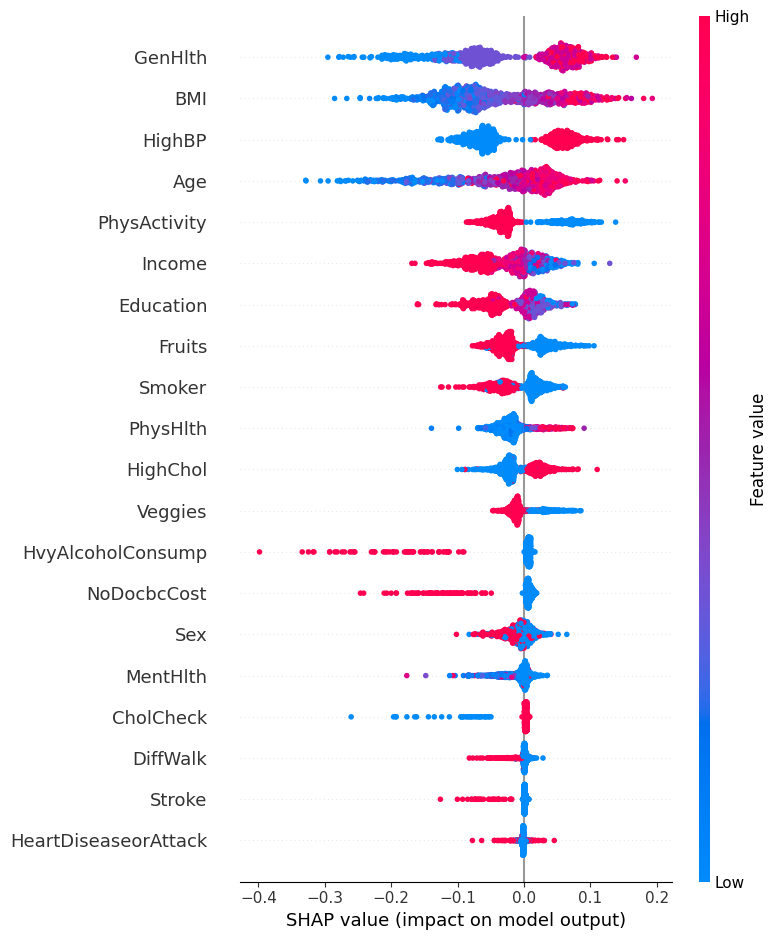

In [17]:
# Generate a SHAP summary plot to see the distribution of feature impacts
shap.summary_plot(shap_values_explanation, X_test_subset)

### Print out all global feature importances

In [18]:
# Calculate mean(|SHAP_VALUE|) for each feature
mean_shap_values = np.mean(np.abs(shap_values_combined), axis=0)

# Print mean(|SHAP_VALUE|) for each feature
print("Global feature importance (mean(|SHAP_VALUE|)):")
for feature, mean_value in zip(X_test_subset.columns, mean_shap_values):
    print(f"{feature}: {mean_value:.4f}")

Global feature importance (mean(|SHAP_VALUE|)):
HighBP: 0.0642
HighChol: 0.0251
CholCheck: 0.0062
BMI: 0.0780
Smoker: 0.0283
Stroke: 0.0034
HeartDiseaseorAttack: 0.0030
PhysActivity: 0.0434
Fruits: 0.0323
Veggies: 0.0179
HvyAlcoholConsump: 0.0178
AnyHealthcare: 0.0026
NoDocbcCost: 0.0166
GenHlth: 0.0862
MentHlth: 0.0139
PhysHlth: 0.0262
DiffWalk: 0.0054
Sex: 0.0145
Age: 0.0617
Education: 0.0343
Income: 0.0407


## SHAP for RF trained on the subset of dataset

Calculating SHAP values with multiprocessing and tqdm...


100%|██████████| 1000/1000 [00:00<00:00, 2193.16it/s]


Plotting SHAP summary bar plot...


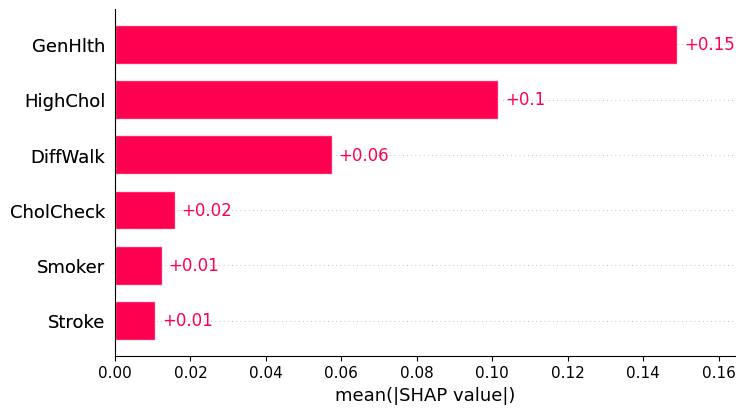

In [19]:
# Select the subset of features
X_subset = X[[
    'DiffWalk',
    'HighChol',
    'Stroke',
    'Smoker',
    'CholCheck',
    'GenHlth'
]]

# Create an explainer for the trained Random Forest model
explainer = shap.TreeExplainer(rf_model_subset)

# Split the data randomly into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42, shuffle=True)

subset_size = 1000
X_test_subset = X_test.iloc[:subset_size]

# Function to calculate SHAP values for a single instance
def calculate_shap_value(index):
    shap_values = explainer.shap_values(X_test_subset.iloc[index:index + 1], check_additivity=False)
    return shap_values if isinstance(shap_values, list) else [shap_values]

# Calculate SHAP values using multiprocessing for parallelization
print("Calculating SHAP values with multiprocessing and tqdm...")
with ProcessPoolExecutor() as executor:
    shap_values_list = list(tqdm(executor.map(calculate_shap_value, range(len(X_test_subset))), total=len(X_test_subset)))

# Combine SHAP values into a single array (ensure correct format)
# Select the SHAP values for class 1 (positive class)
shap_values_combined = np.vstack([shap_values_list[j][0][:, :, 1] for j in range(len(shap_values_list))])  # Select class index 1 for each sample

# Ensure base_values is a numpy array
base_values_array = np.array([explainer.expected_value[1]] * len(X_test_subset))  # Class index 1

# Create an Explanation object
shap_values_explanation = shap.Explanation(
    shap_values_combined,
    base_values=base_values_array,
    data=X_test_subset,
    feature_names=X_test_subset.columns
)

# Plot a global summary using the SHAP bar plot
print("Plotting SHAP summary bar plot...")
shap.plots.bar(shap_values_explanation)

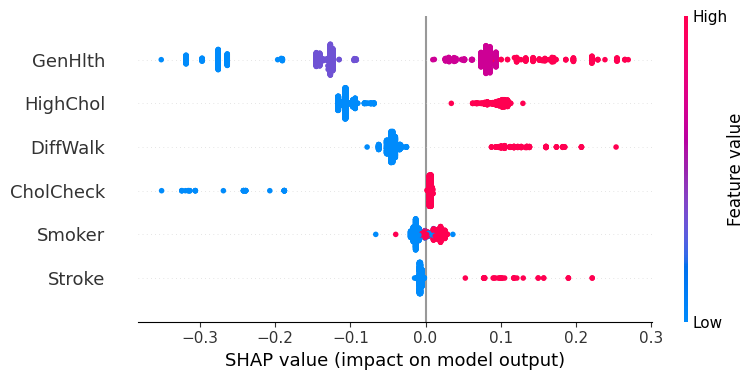

In [20]:
# Generate a SHAP summary plot to see the distribution of feature impacts
shap.summary_plot(shap_values_explanation, X_test_subset)

In [21]:
# Calculate mean(|SHAP_VALUE|) for each feature
mean_shap_values = np.mean(np.abs(shap_values_combined), axis=0)

# Print mean(|SHAP_VALUE|) for each feature
print("Global feature importance (mean(|SHAP_VALUE|)):")
for feature, mean_value in zip(X_test_subset.columns, mean_shap_values):
    print(f"{feature}: {mean_value:.4f}")

Global feature importance (mean(|SHAP_VALUE|)):
DiffWalk: 0.0575
HighChol: 0.1016
Stroke: 0.0107
Smoker: 0.0125
CholCheck: 0.0159
GenHlth: 0.1491


## Discussion on SHAP Values and Model Interpretation

SHAP (SHapley Additive exPlanations) values provide a robust and theoretically sound method for interpreting the contributions of individual features to a model's predictions. In the context of Random Forest models used for binary classification, SHAP values quantify the impact of each feature on the model's output, providing transparency and insight into complex decision-making processes.

### Interpretation of SHAP Values
SHAP values indicate how much each feature contributes to moving the model's output from a baseline value (the expected output of the model) to the final prediction for a given observation. Each SHAP value shows the direction and magnitude of a feature's contribution:

- **Positive SHAP values** push the model's output towards the positive class.
- **Negative SHAP values** push the model's output towards the negative class.

The sum of all SHAP values for a specific instance, along with the baseline value, equals the model's output (typically in probability units, but depending on the configuration, could vary).

### What Does "One Unit" Mean in SHAP Values?
In a Random Forest model trained for binary classification, **"one unit"** typically refers to the units of the model's raw output. In scikit-learn, the raw output for `RandomForestClassifier` is expressed in **probability** rather than log-odds. Therefore:

- **Probability**: SHAP values represent contributions directly in probability units, which is more intuitive for stakeholders, as they show how features impact the probability of the positive class. The SHAP values sum to the predicted probability when `model_output='raw'`. in scikit-learn’s `RandomForestClassifier`, the default is probability output.

### Analysis of Global SHAP Values for the Random Forest Model
When analyzing SHAP values for the Random Forest model trained on the complete dataset versus the subset, we observe some key differences:

- **Full Dataset**: The most influential features include `GenHlth`, `BMI`, `HighBP`, `Age`, and `PhysActivity`, with `GenHlth` having the highest average impact (mean(|SHAP_VALUE|)) at 0.0887. This indicates that overall general health has a significant effect on the prediction of diabetes in this dataset.

- **Subset Dataset**: For the smaller subset, `GenHlth` still stands out as a primary factor with a mean(|SHAP_VALUE|) of 0.1524. Other features such as `HighChol` and `DiffWalk` also show increased prominence. This suggests that in smaller or specific parts of the data, different features may become more pronounced, possibly due to variations in feature distributions or sample-specific characteristics.

### Visualizing the Distribution of Feature Impact
Visualizing SHAP value distributions provides deeper insights into how individual features impact the model:

1. **Summary Plot**: Shows the distribution of SHAP values for each feature across all samples, highlighting which features have consistently strong impacts and how their influence varies with different feature values. Features such as `GenHlth`, `BMI`, and `HighBP` not only have high average impacts but also demonstrate variability in how they affect the prediction.

2. **Bar Plot**: Represents the global importance of features by showing the mean absolute SHAP values. This helps identify which features contribute the most to the model's predictions on average, providing a straightforward way to prioritize variables for further analysis.

### Do We Fully Understand How the Model Works Using SHAP Values?
While SHAP values greatly enhance our understanding of feature contributions, **there are some considerations and uncertainties** to keep in mind:

- **Complex Interactions**: SHAP values explain feature contributions individually, but they may not fully capture complex interactions between features. The assumption of feature independence inherent in some SHAP calculations can lead to biases in certain datasets.

- **Limitations of Approximation**: Depending on the algorithm used (e.g., Tree SHAP, Kernel SHAP), the explanation can be computationally intensive or approximate. In large models or those with highly correlated features, approximations might lead to less precise results.

- **Model Behavior Beyond SHAP**: SHAP values explain a model's predictions but do not inform us about potential issues like overfitting, data leakage, or how well the model generalizes. Combining SHAP analysis with other interpretability methods (e.g., permutation importance or partial dependence plots) can provide a fuller understanding of model behavior.

### Conclusion
The application of SHAP values allows for a detailed exploration of how features impact model predictions, offering clarity in otherwise opaque machine learning models. However, while SHAP helps to illuminate feature contributions, understanding the model in its entirety requires considering the limitations of SHAP and supplementing it with additional analyses. The insights provided by SHAP are valuable for feature selection, model debugging, and communicating results to non-technical stakeholders, ultimately contributing to more transparent and interpretable machine learning models.


# Bayesian Network for Prediction

## Theory of Bayesian Networks

Bayesian networks are a type of probabilistic graphical model that represent a set of variables and their conditional dependencies through a directed acyclic graph (DAG). These networks are powerful tools for modeling uncertainty in complex systems and for reasoning under uncertainty. A Bayesian network consists of:

1. **Nodes**: Represent random variables, which could be observable data, hidden variables, or unknown parameters.
2. **Edges**: Directed edges between nodes indicate direct dependencies between the variables. If there is a directed edge from node \( A \) to node \( B \), \( A \) is said to be a parent of \( B \).
3. **Conditional Probability Distributions (CPDs)**: Each node has an associated CPD that quantifies the effect of its parents on the node.

Bayesian networks allow us to encode domain knowledge and model causal relationships. They are useful in tasks such as classification, prediction, and anomaly detection, where understanding the interdependence between variables is essential.

## Properties of Bayesian Networks

- **Probabilistic Inference**: Given observed evidence, Bayesian networks can be used to update the probabilities of unknown variables.
- **Markov Property**: A variable is conditionally independent of its non-descendants given its parents.
- **Learning**: The structure of a Bayesian network can be learned from data using algorithms such as the PC algorithm or through domain expertise.

## Steps in Creating a Bayesian Network for Prediction

1. **Data Preparation**: Load the data, balance it using techniques like SMOTE for class imbalance, and split it into training and testing sets.
2. **DAG Construction**: Define the structure of the Bayesian network, either through structure learning algorithms or based on domain knowledge.
3. **Parameter Estimation**: Use methods such as Maximum Likelihood Estimation (MLE) to estimate the CPDs of the network.
4. **Inference**: Use the trained network to make predictions and evaluate its performance using metrics like precision, recall, and ROC curves.

For this Bayesian Network. We selct the subgraph that we got from structure learning using the PC algorithm. We use the
*GenHlth* variable with all its parents. See the figure below

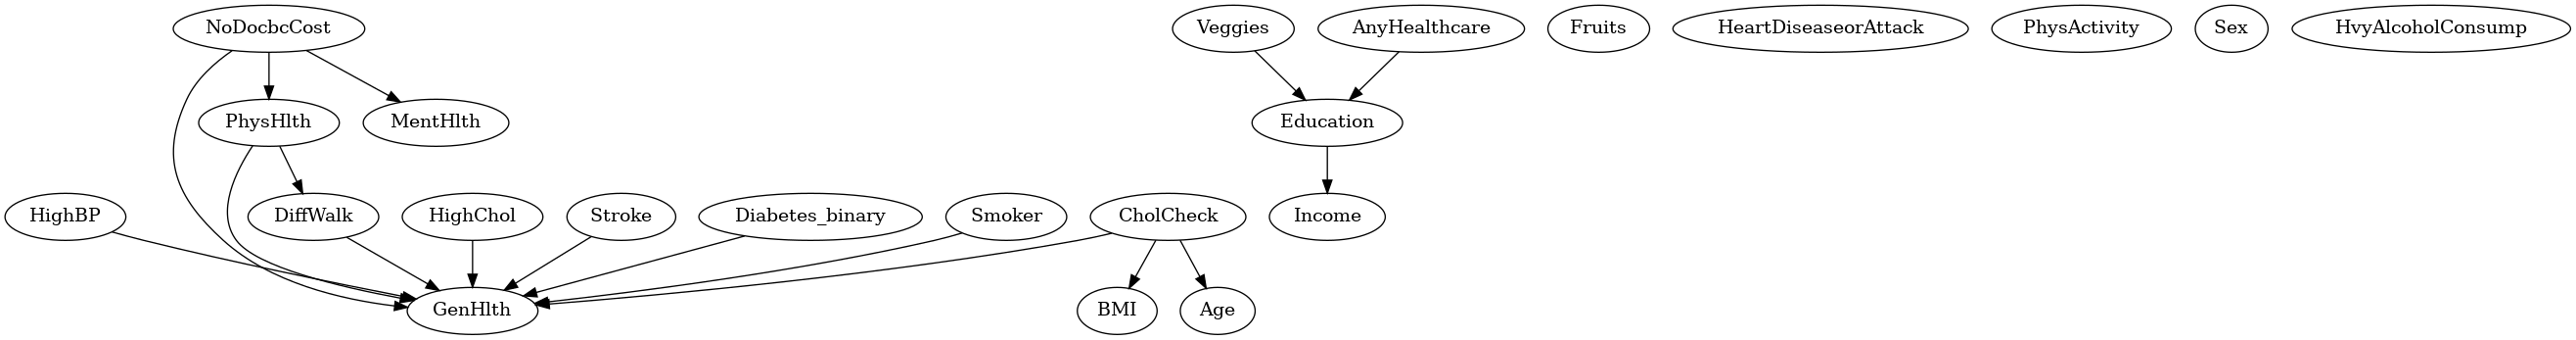

In [22]:
Image(filename="learned_dag_p01_maxcond_5.png")

In [23]:
# Causal inference and Bayesian models
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Define the subset of selected features
selected_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 
    'Stroke', 'GenHlth', 'DiffWalk', 'Diabetes_binary'
]

# Add the target variable 'Diabetes_binary' to the dataset
X = X.assign(Diabetes_binary=y)

# Split the data into training and testing sets (70/30 split)
train_data, test_data = train_test_split(X[selected_features], test_size=0.3, random_state=42)

# Separate features and target for SMOTE
X_train = train_data.drop(columns=['Diabetes_binary'])
y_train = train_data['Diabetes_binary']

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Combine the balanced data for training the Bayesian Network
train_data_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
train_data_balanced['Diabetes_binary'] = y_train_balanced

# Define the structure of the Bayesian Network
model = BayesianNetwork([
    ('HighBP', 'GenHlth'),
    ('DiffWalk', 'GenHlth'),
    ('HighChol', 'GenHlth'),
    ('Stroke', 'GenHlth'),
    ('Diabetes_binary', 'GenHlth'),
    ('Smoker', 'GenHlth'),
    ('CholCheck', 'GenHlth')
])

# Train the Bayesian Network using Maximum Likelihood Estimation
model.fit(train_data_balanced, estimator=MaximumLikelihoodEstimator)

# Ensure that the model is valid
assert model.check_model(), "The model has inconsistencies or missing CPDs"

# Prepare test data by dropping the target variable
X_test = test_data.drop(columns=['Diabetes_binary'])

# Predict on the test set
predictions = model.predict(X_test)

# Print the classification report
print("\nBayesian Network Classification Report:")
print(classification_report(test_data['Diabetes_binary'], predictions['Diabetes_binary']))

100%|██████████| 269/269 [00:08<00:00, 30.37it/s]
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()



Bayesian Network Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75     65605
           1       0.23      0.67      0.34     10499

    accuracy                           0.64     76104
   macro avg       0.57      0.65      0.54     76104
weighted avg       0.83      0.64      0.69     76104



/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value en

### ROC Curve

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


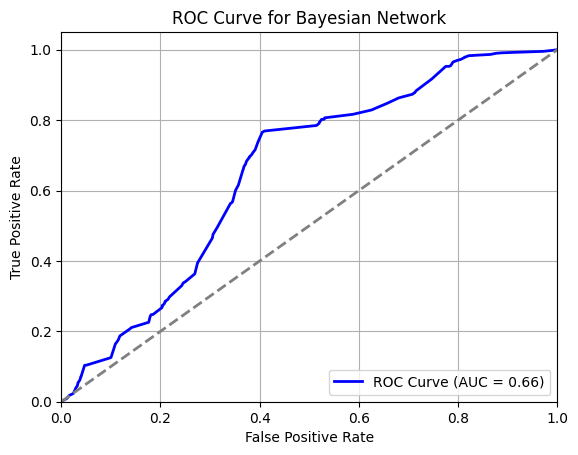

In [24]:
# Predict probabilities on the test set using PGMPY's predict_probability method
y_prob = model.predict_probability(X_test)

# Extract the probabilities for the positive class (Diabetes_binary = 1)
predicted_probs = y_prob['Diabetes_binary_1']

# Replace NaN values with 0 (or another appropriate value if needed)
predicted_probs = predicted_probs.fillna(0)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(test_data['Diabetes_binary'], predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bayesian Network')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Domain Knowledge and intuition

The construction of the Bayesian Network for diabetes prediction was driven by a combination of domain knowledge, intuition, and data analysis. Below, we outline the rationale behind the selected structure:

1. **Core Health Indicators**:
   - **Age**: A significant factor influencing various health conditions. It was modeled to affect both **General Health (GenHlth)** and conditions like **High Blood Pressure (HighBP)**, given that aging is associated with an increased risk of these issues.
   - **BMI (Body Mass Index)**: A key predictor of metabolic health, connected to **HighBP** and **High Cholesterol (HighChol)**, as higher BMI is often associated with an increased risk of cardiovascular conditions.
   - **General Health (GenHlth)**: A comprehensive measure influenced by other health conditions like **DiffWalk (Difficulty Walking)** and **PhysHlth (Physical Health)**, as these factors contribute to an individual's overall health perception.

2. **Direct Influences on Heart and Stroke Conditions**:
   - **HighBP** and **HighChol** were linked to **Heart Disease or Attack (HeartDiseaseorAttack)**, reflecting established medical findings that hypertension and high cholesterol are major risk factors for cardiovascular events.
   - **HeartDiseaseorAttack** was modeled to impact **Stroke**, aligning with clinical understanding that a history of heart disease increases the likelihood of stroke.

3. **Diabetes as a Target Outcome**:
   - **GenHlth**, **HighBP**, and **HighChol** were directly connected to **Diabetes_binary** to represent their collective impact on diabetes risk. This is consistent with the understanding that overall health status and conditions like hypertension and high cholesterol are predictors of diabetes.
   - **Stroke** was included as a potential contributing factor to diabetes, as metabolic and vascular changes associated with stroke can relate to diabetes risk.

4. **Interactions and Health Dependencies**:
   - **DiffWalk** and **PhysHlth** were connected to **GenHlth**, acknowledging that mobility issues and physical health significantly influence one's overall health status.
   - The directed edges in the network were chosen to represent plausible causal relationships based on medical literature and practical experience, rather than purely statistical associations.


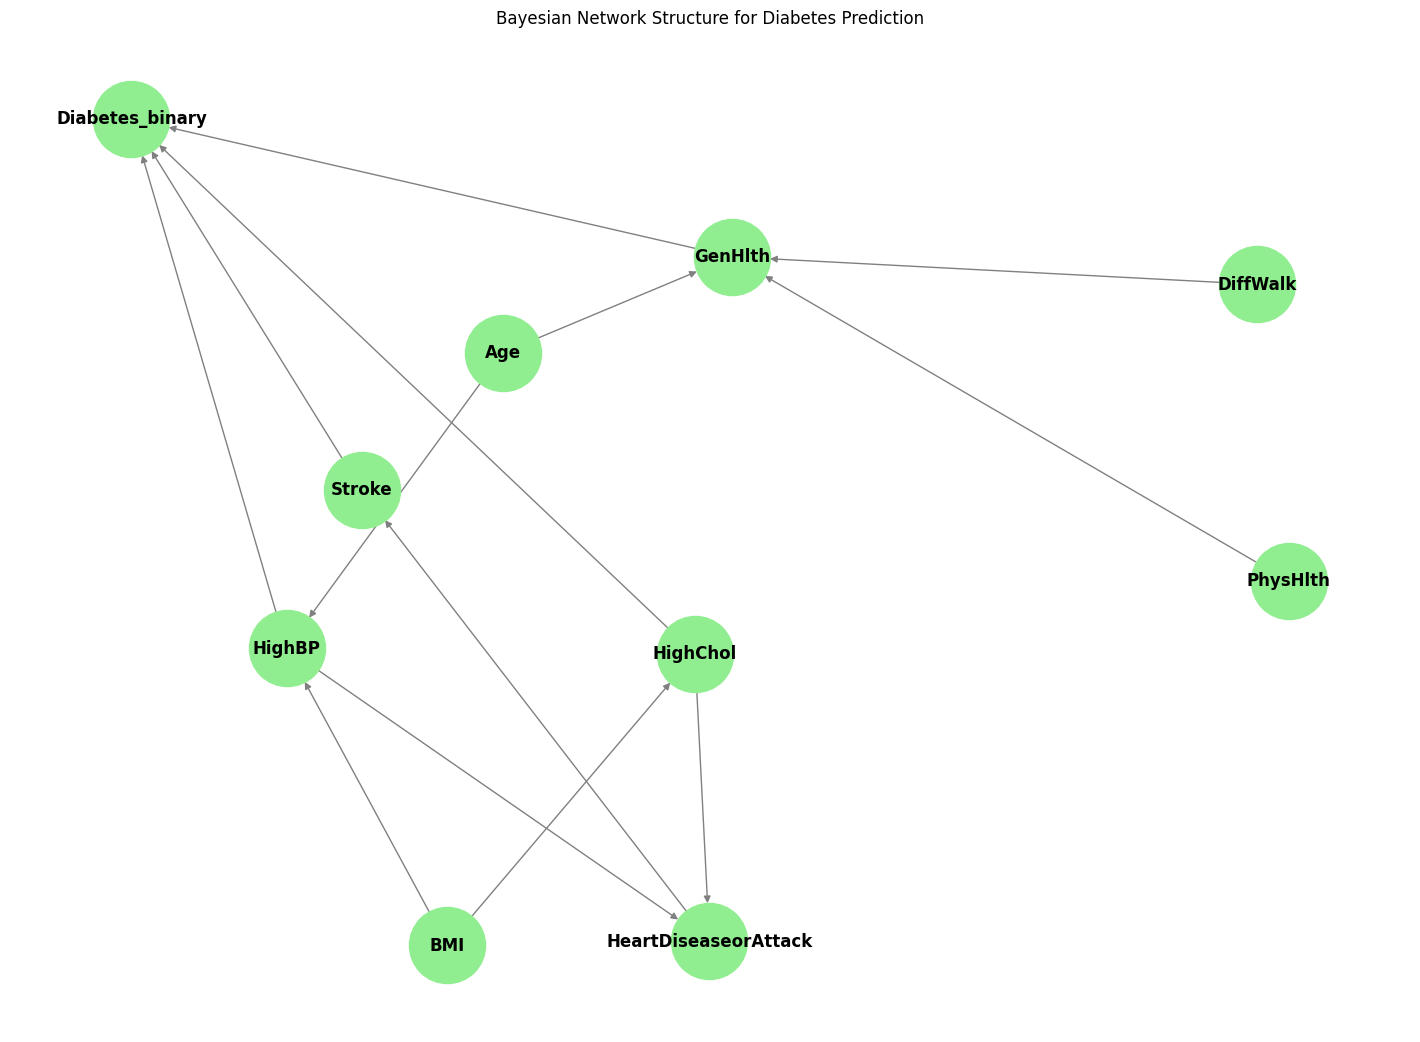

In [25]:

# Visualize the DAG using matplotlib and networkx
import matplotlib.pyplot as plt
import networkx as nx

model = BayesianNetwork([
    ('Age', 'GenHlth'),
    ('Age', 'HighBP'),
    ('BMI', 'HighBP'),
    ('BMI', 'HighChol'),
    ('HighBP', 'HeartDiseaseorAttack'),
    ('HighChol', 'HeartDiseaseorAttack'),
    ('HeartDiseaseorAttack', 'Stroke'),
    ('Stroke', 'Diabetes_binary'),
    ('HighBP', 'Diabetes_binary'),
    ('HighChol', 'Diabetes_binary'),
    ('GenHlth', 'Diabetes_binary'),
    ('DiffWalk', 'GenHlth'),
    ('PhysHlth', 'GenHlth')
])

# Get the structure of the Bayesian Network
edges = model.edges()

# Create a directed graph
graph = nx.DiGraph()
graph.add_edges_from(edges)

# Draw the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(graph, seed=42)  # Positioning for nodes
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=12, font_weight='bold', edge_color='gray')
plt.title('Bayesian Network Structure for Diabetes Prediction')
plt.show()

In [26]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Define the subset of selected features based on correlation
selected_features = [
    'GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol',
    'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'Diabetes_binary'
]

# Add the target variable 'Diabetes_binary' to the dataset
X = X[selected_features[:-1]]  # Exclude the target variable from features
X = X.assign(Diabetes_binary=y)

# Split the data into training and testing sets (70/30 split)
train_data, test_data = train_test_split(X, test_size=0.3, random_state=42)

# Separate features and target for SMOTE
X_train = train_data.drop(columns=['Diabetes_binary'])
y_train = train_data['Diabetes_binary']

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Combine the balanced data for training the Bayesian Network
train_data_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
train_data_balanced['Diabetes_binary'] = y_train_balanced

# Define a Bayesian Network structure based on domain knowledge and intuition
model = BayesianNetwork([
    ('Age', 'GenHlth'),
    ('Age', 'HighBP'),
    ('BMI', 'HighBP'),
    ('BMI', 'HighChol'),
    ('HighBP', 'HeartDiseaseorAttack'),
    ('HighChol', 'HeartDiseaseorAttack'),
    ('HeartDiseaseorAttack', 'Stroke'),
    ('Stroke', 'Diabetes_binary'),
    ('HighBP', 'Diabetes_binary'),
    ('HighChol', 'Diabetes_binary'),
    ('GenHlth', 'Diabetes_binary'),
    ('DiffWalk', 'GenHlth'),
    ('PhysHlth', 'GenHlth')
])

# Train the Bayesian Network using Maximum Likelihood Estimation on the balanced data
model.fit(train_data_balanced, estimator=MaximumLikelihoodEstimator)

# Ensure that the model is valid
assert model.check_model(), "The model has inconsistencies or missing CPDs"

# Prepare test data by dropping the target variable
X_test = test_data.drop(columns=['Diabetes_binary'])

# Predict on the test set
predictions = model.predict(X_test)

# Print the classification report
print("\nBayesian Network Classification Report:")
print(classification_report(test_data['Diabetes_binary'], predictions['Diabetes_binary']))

100%|██████████| 29993/29993 [00:48<00:00, 620.37it/s]



Bayesian Network Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.76     65605
           1       0.26      0.81      0.39     10499

    accuracy                           0.65     76104
   macro avg       0.61      0.72      0.57     76104
weighted avg       0.86      0.65      0.70     76104



### ROC Curve

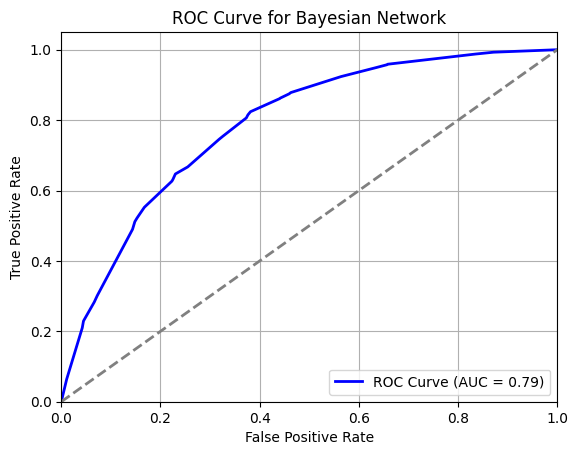

In [27]:
# Predict probabilities on the test set using PGMPY's predict_probability method
y_prob = model.predict_probability(X_test)

# Extract the probabilities for the positive class (Diabetes_binary = 1)
predicted_probs = y_prob['Diabetes_binary_1']

# Replace NaN values with 0 (or another appropriate value if needed)
predicted_probs = predicted_probs.fillna(0)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(test_data['Diabetes_binary'], predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bayesian Network')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Discussion of Results

**Bayesian Network with Structure Learned via PC Algorithm**

The results from training a Bayesian network using the DAG learned from the PC algorithm were as follows:

- **Precision** for class 0 was high at 0.92, indicating that the network is effective at correctly identifying true negatives.
- **Recall** for class 1 was relatively high at 0.67, suggesting a good ability to detect true positives.
- The **accuracy** of 0.64 and **weighted average F1-score** of 0.69 suggest a moderate overall performance with a tendency to favor the majority class (0).
- The results indicate that the learned structure captures significant relationships but may not fully exploit domain-specific causal relationships.

**Bayesian Network with Domain Knowledge-Based DAG**

The results from training the Bayesian network using a DAG informed by domain expertise showed:

- **Precision** for class 0 was higher at 0.95, showing even greater specificity in correctly identifying true negatives.
- **Recall** for class 1 improved to 0.81, showing a stronger ability to identify true positives, leading to a higher F1-score for this class.
- The overall **accuracy** was 0.65, and the **weighted average F1-score** was 0.70, slightly higher than the learned structure approach.

**Comparison and Insights**

- The domain knowledge-based Bayesian network outperformed the structure learned from the PC algorithm in terms of identifying true positives, as evidenced by the higher recall for class 1 and overall precision for class 0.
- The increase in performance when using a domain-informed DAG suggests that integrating expert knowledge can guide the model to learn more meaningful relationships and improve predictive power.
- While structure learning algorithms like the PC algorithm are useful for discovering hidden relationships, domain expertise remains invaluable for refining and validating these models.

These findings underscore the importance of leveraging domain knowledge in conjunction with automated structure learning for complex models such as Bayesian networks. The combination can lead to more robust and interpretable models for practical applications, particularly in healthcare and diagnostics, where understanding causal relationships is critical.

# Final Conclusion

The results of this study highlight the significant advantages of incorporating causal reasoning and domain knowledge into machine learning models for predicting diabetes. By combining data-driven approaches with domain expertise, we observed the following:

- **Enhanced Model Interpretability**: Integrating causality through a domain-informed DAG not only improved the model's predictive power but also provided clear insights into feature relationships, strengthening the interpretability of predictions.
- **Improved Performance**: Models trained on features identified by the causally-informed Bayesian network outperformed traditional models and those using automated structure learning algorithms, with notable improvements in recall and overall F1-score.
- **Explainability Gains**: SHAP value analysis demonstrated that causally relevant features contributed significantly to prediction accuracy, validating the importance of understanding and integrating domain knowledge.
- **Dataset Complexity**: The dataset's complexity was evident in that no single variable showed a strong correlation with the predictive variable, `Diabetes_binary`. This complexity was particularly demonstrated by the PC algorithm, which often resulted in DAGs that excluded connections to `Diabetes_binary`.
- **Bayesian Networks vs. Other Models**: One of the best results was achieved by incorporating DAGs and Bayesian networks into the classification process. However, Random Forests also showed good performance. When used alongside explainability methods like SHAP, these models help in understanding some of the dataset's complexity, though their inner workings remain less transparent compared to logistic regression or Bayesian networks.

In conclusion, the combination of machine learning, causal inference, and expert insight yields a powerful framework for creating more accurate, interpretable, and reliable models. This approach is particularly valuable in healthcare applications, where understanding causal pathways can inform better decision-making and patient outcomes. Future work could explore incorporating more complex causal models and expanding the analysis to include longitudinal data for a deeper understanding of causal dynamics over time.